In [86]:
# Import the necessary libraries
import pandas as pd 
import numpy as np 
import sys
import os
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import to_hex

from sklearn.metrics import mean_squared_error, mean_absolute_error


from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import cross_val_score
import time
#import warnings
import warnings
warnings.filterwarnings("ignore")

## Load and Prepare the Dataset

In [87]:
df_all = pd.read_csv("D:\\OneDrive - HvA\\LTP company\\Forecasting\\Dataset official\\df_top_10_products.csv")

# Drop irrelevant columns
df_all.drop(columns=['Unit price', 'Discount', 'Product group'], inplace=True)

# Type conversion
df_all['ProductCode'] = df_all['ProductCode'].astype('category')
df_all['Order date'] = pd.to_datetime(df_all['Order date'])

# Group to weekly sales
weekly_sales_all = df_all.groupby(['ProductCode', pd.Grouper(key='Order date', freq='W-MON')])['Quantity'] \
                        .sum().reset_index()
weekly_sales_all.rename(columns={'Order date': 'WeekStart', 'Quantity': 'WeeklySales'}, inplace=True)


## Feature engineering

In [88]:
#change the product code to categorical
weekly_sales_all['ProductCode'] = weekly_sales_all['ProductCode'].astype('category')


In [89]:
#the number of rows in weekly_sales_all
print(f"Number of rows in weekly_sales_all: {len(weekly_sales_all)}")

Number of rows in weekly_sales_all: 1230


In [90]:
#check the number of rows has zero values in weekly sales
zero_sales = weekly_sales_all["WeeklySales"]==0
print(f"Number of rows with zero weekly sales: {zero_sales.sum()}")

Number of rows with zero weekly sales: 216


In [91]:
#drop the rows with zero weekly sales
weekly_sales_all = weekly_sales_all[weekly_sales_all['WeeklySales'] > 0]
#check the number of rows after dropping the zero weekly sales
print(f"Number of rows after dropping zero weekly sales: {len(weekly_sales_all)}")

Number of rows after dropping zero weekly sales: 1014


In [92]:
# Function to split the data into train, validation, and test sets
def split_data(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    train_list, val_list, test_list = [], [], []

    for product, group in df.groupby("ProductCode"):
        group = group.sort_values("WeekStart")
        total_weeks = len(group)
        
        # Minimum weeks check
        if total_weeks < 30:
            continue

        n_train = int(total_weeks * train_ratio)
        n_val = int(total_weeks * val_ratio)
        n_test = total_weeks - n_train - n_val  # balance remainder

        train = group.iloc[:n_train]
        val = group.iloc[n_train:n_train + n_val]
        test = group.iloc[n_train + n_val:]

        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    return pd.concat(train_list), pd.concat(val_list), pd.concat(test_list)



In [93]:
def add_lag_diff_features(df, lags, diffs):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('ProductCode')['WeeklySales'].shift(lag)
    for diff in diffs:
        df[f'diff_{diff}'] = df.groupby('ProductCode')['WeeklySales'].diff(diff)
    return df

In [94]:
train_data, val_data, test_data = split_data(weekly_sales_all)

In [95]:
#print the length of each dataset
print(f"Length of training data: {len(train_data)}")
print(f"Length of validation data: {len(val_data)}")
print(f"Length of test data: {len(test_data)}")

Length of training data: 705
Length of validation data: 147
Length of test data: 162


In [96]:
lags = [1, 2, 3, 4, 13, 26, 52]
diffs = [1, 2, 3, 4, 13, 26, 52]

train_data = add_lag_diff_features(train_data, lags, diffs)
val_data = add_lag_diff_features(val_data, lags, diffs)
test_data = add_lag_diff_features(test_data, lags, diffs)


In [97]:
train_data.head()

,ProductCode,WeekStart,WeeklySales,lag_1,lag_2,lag_3,lag_4,lag_13,lag_26,lag_52,diff_1,diff_2,diff_3,diff_4,diff_13,diff_26,diff_52
1,1103,2023-01-09,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1103,2023-01-16,22.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,-79.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1103,2023-01-23,797.0,22.0,101.0,NaN,NaN,NaN,NaN,NaN,775.0,696.0,NaN,NaN,NaN,NaN,NaN
4,1103,2023-01-30,6.0,797.0,22.0,101.0,NaN,NaN,NaN,NaN,-791.0,-16.0,-95.0,NaN,NaN,NaN,NaN
5,1103,2023-02-06,49.0,6.0,797.0,22.0,101.0,NaN,NaN,NaN,43.0,-748.0,27.0,-52.0,NaN,NaN,NaN


In [98]:
#identify the features and target variable
list_columns = train_data.columns.tolist()
features_all = [col for col in list_columns if col not in ['WeekStart', 'WeeklySales']]
print(f"Features used for modeling: {features_all}")

Features used for modeling: ['ProductCode', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_13', 'lag_26', 'lag_52', 'diff_1', 'diff_2', 'diff_3', 'diff_4', 'diff_13', 'diff_26', 'diff_52']


In [99]:
#target variable
target_all = 'WeeklySales'

In [100]:
# Split features and targets
X_train_all = train_data[features_all].copy()
y_train_all = train_data[target_all]

X_val_all = val_data[features_all].copy()
y_val_all = val_data[target_all]

X_test_all = test_data[features_all].copy()
y_test_all = test_data[target_all]

# Ensure 'ProductCode' is categorical
for df in [X_train_all, X_val_all, X_test_all]:
    df['ProductCode'] = df['ProductCode'].astype('category')

# Get index of categorical features
cat_feature_index = [X_train_all.columns.get_loc('ProductCode')]

In [101]:
# Model
model = LGBMRegressor()

In [102]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error
import time

# Define parameter grid to search
param_grid2 = {
    'learning_rate': [0.03, 0.05],
    'max_depth': [4, 5],
    'num_leaves': [20, 25],
    'min_data_in_leaf': [30, 40],
    'reg_alpha': [0.3, 0.5],
    'reg_lambda': [0.3, 0.5],
    'n_estimators': [300, 500]
}

# Base model
base_model = LGBMRegressor()

# Fit parameters using the validation set
fit_params2 = {
    "eval_set": [(X_val_all, y_val_all)],
    "eval_metric": "mse",
    "categorical_feature": cat_feature_index,
    "callbacks": [early_stopping(30), log_evaluation(10)]
}

# GridSearchCV setup
grid2 = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid2,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Train the model and track time
start2 = time.time()
grid2.fit(X_train_all, y_train_all)
train_time2 = time.time() - start2

# Best model prediction on test set
best_model = LGBMRegressor(**grid2.best_params_)
best_model.fit(
    X_train_all, y_train_all,
    eval_set=[(X_val_all, y_val_all)],
    eval_metric='mse',
    categorical_feature=cat_feature_index,
    callbacks=[early_stopping(30), log_evaluation(10)]
)

# Predict
start = time.time()
y_train_pred = best_model.predict(X_train_all)
y_val_pred = best_model.predict(X_val_all)
y_test_pred = best_model.predict(X_test_all)
predict_time = time.time() - start

# Evaluate
mse = mean_squared_error(y_test_all, y_test_pred)
rmse = np.sqrt(mse)



Fitting 3 folds for each of 128 candidates, totalling 384 fits


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 15
[LightGBM] [Info] Start training from score 142.851064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

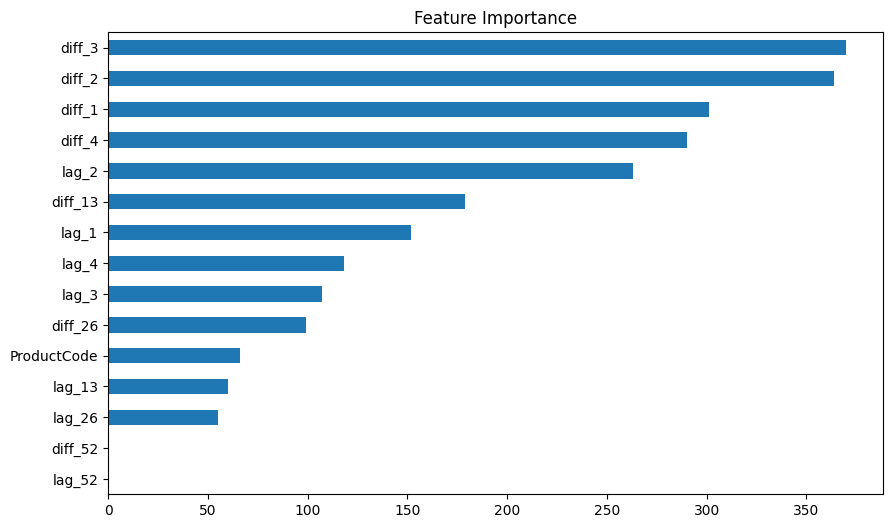

In [103]:
import matplotlib.pyplot as plt

lgb_importances = pd.Series(best_model.feature_importances_, index=X_train_all.columns)
lgb_importances.sort_values().plot(kind='barh', figsize=(10, 6), title="Feature Importance")
plt.show()

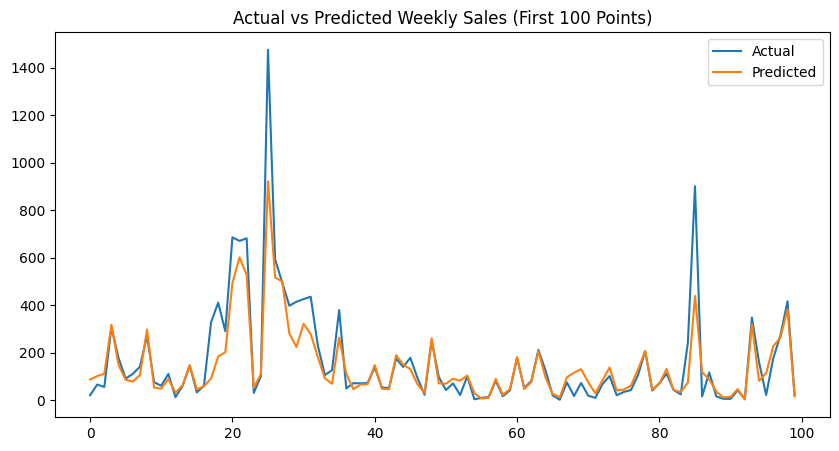

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_all.values[:100], label='Actual')
plt.plot(y_test_pred[:100], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Weekly Sales (First 100 Points)')
plt.show()


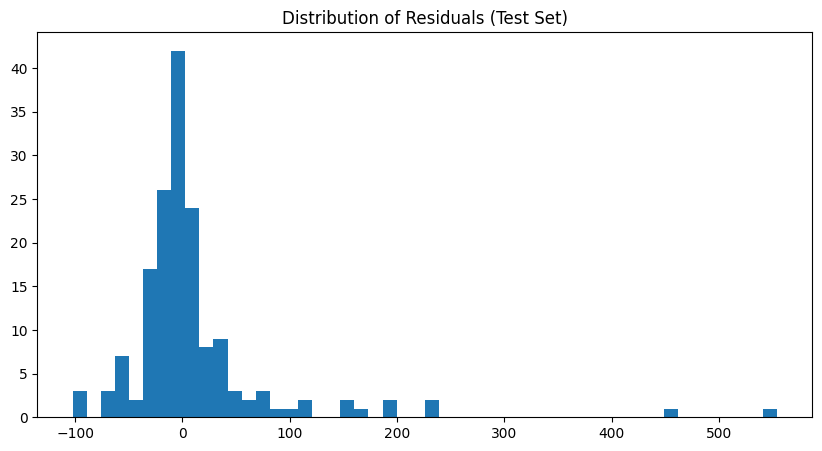

In [105]:
residuals = y_test_all - y_test_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50)
plt.title("Distribution of Residuals (Test Set)")
plt.show()


In [106]:
overfit_index = (val_rmse - train_rmse) / train_rmse
print(f"Overfit index: {overfit_index:.3f}")


Overfit index: 3.133


In [107]:
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train_all, y_train_pred)
val_r2 = r2_score(y_val_all, y_val_pred)
test_r2 = r2_score(y_test_all, y_test_pred)

In [108]:
print(f"Train R2: {train_r2:.3f}")
print(f"Validation R2: {val_r2:.3f}")
print(f"Test R2: {test_r2:.3f}")

Train R2: 0.983
Validation R2: 0.766
Test R2: 0.828
